In [9]:
from glob import glob
import os
from pathlib import Path
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
import pygrib
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
from datetime import datetime
from dateutil import tz

In [10]:
grib_dir = Path('.') / 'data'
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [28]:
# Download files
date = 20200709
run = '06'
fhr = 24
left_lon = 360-90
right_lon = 360-77
top_lat = 36
bottom_lat = 24

nomads_url = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{run}z.conus.prob.f{fhr}.grib2'
              '&all_lev=on&var_APCP=on&subregion='
              f'&leftlon={left_lon}&rightlon={right_lon}&toplat={top_lat}&bottomlat={bottom_lat}&'
              f'dir=/href.{date}/ensprod')

def download_gribfilter(file_url):
    with closing(request.urlopen(file_url)) as r:
        with open(f'{grib_dir}/href/href.t{run}z.conus.prob.precip.f{fhr}.grib2', 'wb') as f:
            shutil.copyfileobj(r, f)
        
download_gribfilter(nomads_url)

In [31]:
#%%capture
# Read in files and acquire data needed for plotting
ds = pygrib.open(f'{grib_dir}/href/href.t{run}z.conus.prob.precip.f{fhr}.grib2')

# Reset the grib messages to 0 so you're at beginning of the file
ds.seek(0)

# Get grib message
# For reference, here are the corresponding grib messages with QPF exceedance
# 26 = 0.10; 27 = 0.25, 28 = 0.50; 29 = 1.00; 30 = 2.00; 31 = 3.00; 32 = 5.00
ds = ds[30]

# Extract lats, lons, and data values
lats, lons = ds.latlons()
href_values = ds.values

def convert_datetime(pygrib_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

# Get the date and time of the forecast
dt = str(ds.validityDate) + ' ' + str(ds.validityTime)
VALID_TIME = convert_datetime(dt)

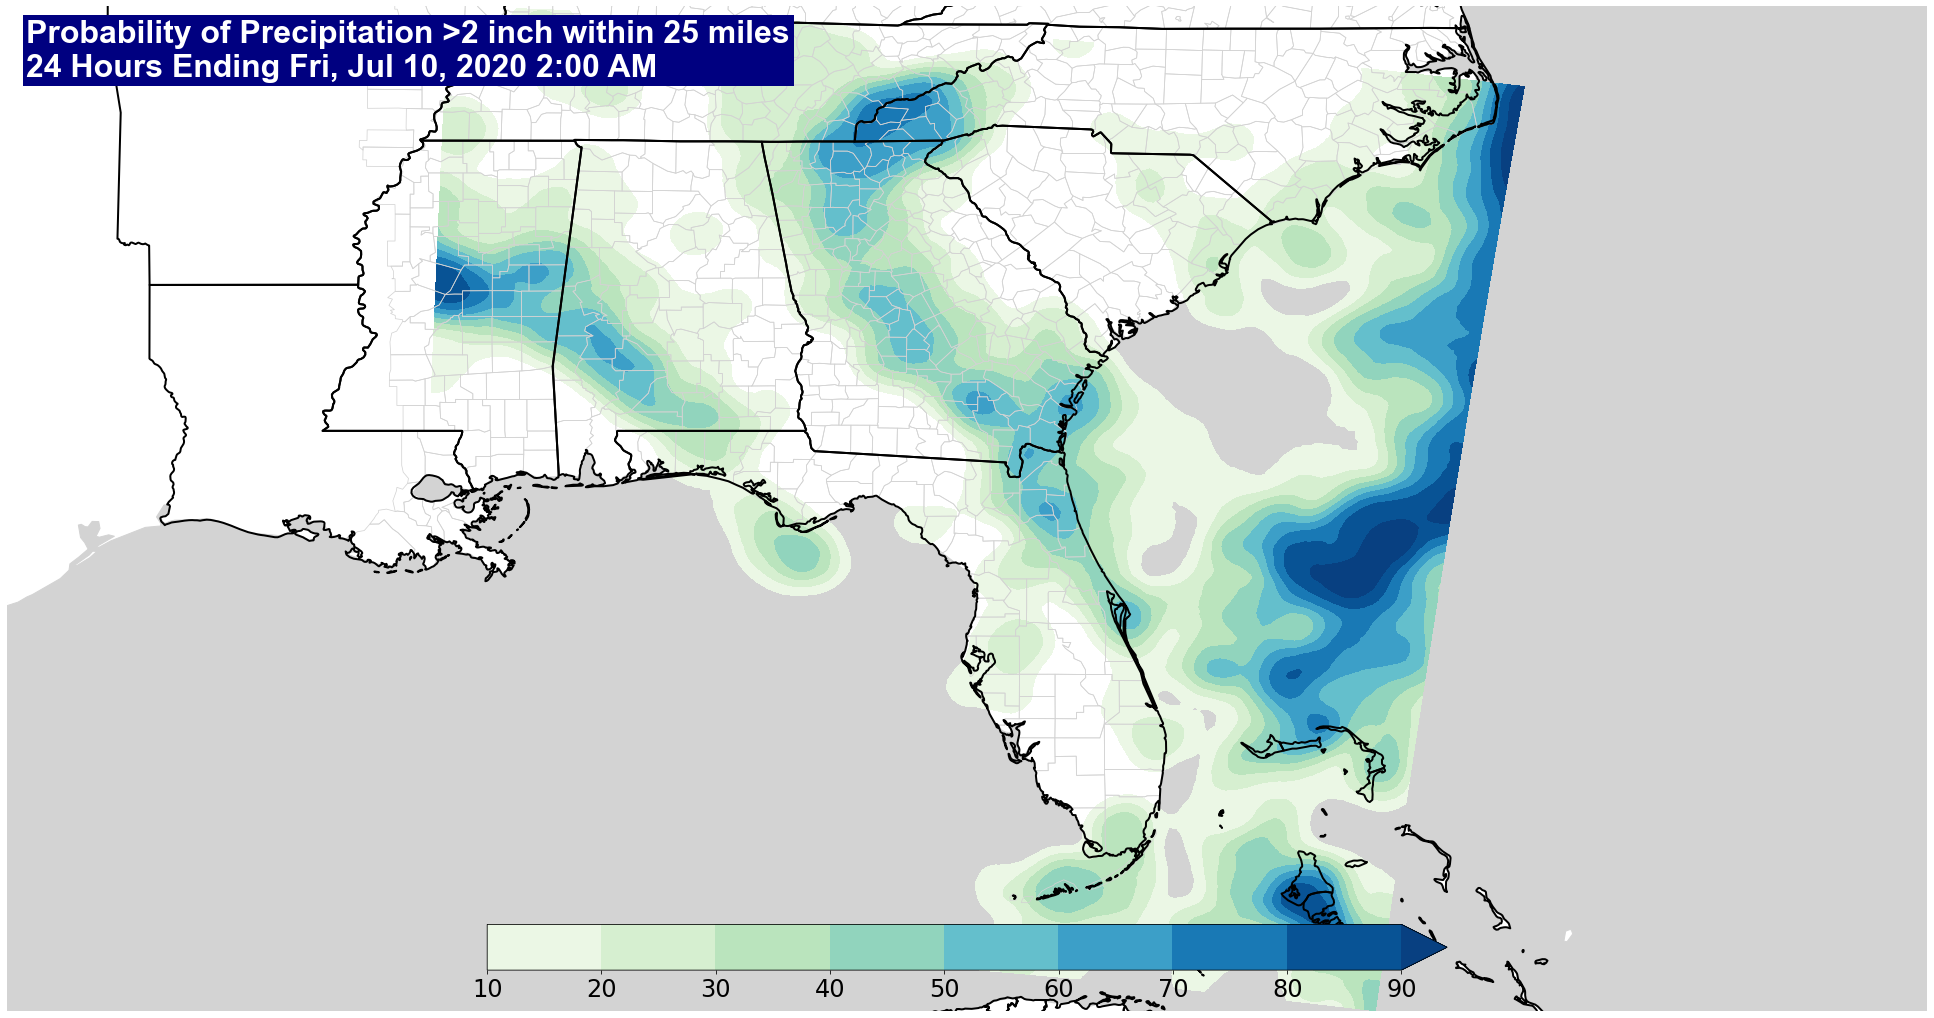

In [32]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
# ax.set_extent([left_lon - 6, right_lon + 6, bottom_lat - 8, top_lat + 7])


data_range = [num for num in np.arange(10, 100, 10)]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.GnBu, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title(f'Probability of Precipitation >2 inch within 25 miles\n24 Hours Ending {VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
plt.savefig(f'{graphics_dir}/precip-2in_{fhr}.png', dpi=72)
plt.show()